In [1]:
import sys
import numpy as npy
from scipy import interpolate
import math
import scipy.misc as sm
import matplotlib.pyplot as plt
# make graphics inline
%matplotlib inline
from ptycho_trans import *

Define the input parameters (scan_num,sign,n_iterations,mode_flag,multislice_flag):

In [2]:
# save_dir+...+'_'+self.scan_num+'_'+self.sign
scan_num = 1 #scan number:  
sign = 'hxn' #saving file name

n_iterations = 50

mode_flag = False
multislice_flag = False

Define the general parameters of the HXN application

In [3]:
energy     = 8000*1.60217657e-19 # 8 keV in J
pixel_size      =  55 * 1e-6 # 55 um pixels
real_pixel_size =  5.5 * 1e-9 # real space pixel size in m

Load the probe file:

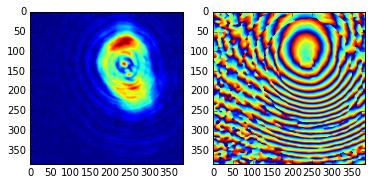

In [4]:
probeFile  = './hxn/probe.npy'
probe = npy.load(probeFile) # (384, 384)

plt.subplot(1,2,1)
plt.imshow(abs(probe))
plt.subplot(1,2,2)
plt.imshow(np.angle(probe))

In [5]:
# Detector side in pixels
nx_prb = probe.shape[0] 
ny_prb = probe.shape[1] 
det_side = nx_prb
print det_side

384


Load a file with a sequence of the scan x-y points and shift them into the positive plane: 

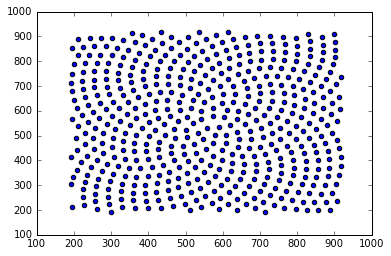

In [6]:
scanFile   = './hxn/scan.npy'
points  = np.load(scanFile)

X = points[0] # [-363, 362]
Y = points[1] # [-363, 363]

X -= min(X)
Y -= min(Y) 

X += det_side/2
Y += det_side/2

plt.scatter(X, Y)
plt.show()

points[0] = X
points[1] = Y

In [7]:
print min(X), max(X), min(Y), max(Y)

192.0 917.0 192.0 918.0


Load the object file:

In [8]:
objectFile = './hxn/object.npy'
object = npy.load(objectFile) # (1170, 1172)

nx_obj = max(X) - min(X) + probe.shape[0] + 10
ny_obj = max(Y) - min(Y) + probe.shape[1] + 10

nx_obj = nx_obj + np.mod(nx_obj, 2)
ny_obj = ny_obj + np.mod(ny_obj, 2)

print nx_obj, ny_obj, object.shape[0], object.shape[1]

1120.0 1120.0 1170 1172


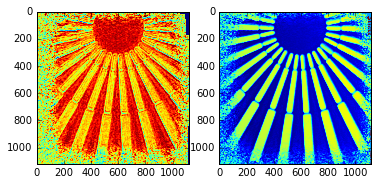

In [9]:
object = object[0: int(nx_obj), object.shape[1] - int(ny_obj): object.shape[1]]

plt.subplot(1,2,1)
plt.imshow(abs(object))
plt.subplot(1,2,2)
plt.imshow(np.angle(object))

In [10]:
object.shape

(1120, 1120)

Generate frames

In [11]:
# tmp = npy.load('./diff_fermat.npy')

nframes = X.size

objFrames = npy.empty((nframes, nx_prb, ny_prb), dtype = complex)
detFrames = npy.empty((nframes, nx_prb, ny_prb))
tmp = npy.empty((nx_prb, ny_prb, nframes))

for i in range(0,nframes):
    ix = int(X[i])
    iy = int(Y[i])
    objFrames[i] = object[ix - det_side/2: ix + det_side/2, iy - det_side/2: iy + det_side/2]
    tmp[:,:,i] = np.abs(np.fft.fft2(probe*objFrames[i]))/np.sqrt(1.*det_side*det_side)

nx,ny,nz = npy.shape(tmp)
print nx, ny, nz

384 384 512


Shift data center to corner

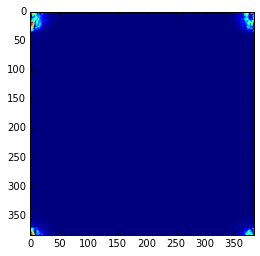

In [12]:
plt.imshow(tmp[:,:,0])

Create data list and initialize ptycho_trans

In [13]:
diffamp = [npy.copy(tmp[:,:,i]) for i in range(nz)]
del(tmp)
recon = ptycho_trans(diffamp)

Using pyfftw


Beamline parameters

In [14]:
recon.x_roi = nx              #data array size in x
recon.y_roi = ny              #data array size in y

recon.ccd_pixel_um =  pixel_size     #detector pixel size, 55 (um)

wavelength = 1.98644e-25/energy # 1.5497979726416796e-10
recon.lambda_nm = wavelength*1.e+9  # x-ray wavelength, 0.1 (nm) -> 0.155

distance   = (det_side * pixel_size * real_pixel_size)/ wavelength # 0.749517047064
recon.z_m =  distance  # detector-to-sample distance, 1 (m) -> 0.749517047064

Scan parameters

In [15]:
# round, mesh and fermat
recon.cal_scan_pattern_flag = False
recon.points = points
recon.num_points = nz

Probe parameters

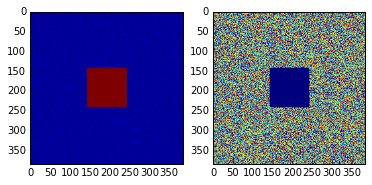

In [16]:
recon.init_prb_flag = False  #True to start with a random guess. False to load a pre-existing array

recon.prb = probe
recon.prb = npy.load('./prb_init.npy')

recon.nx_prb = nx
recon.ny_prb = ny

recon.start_update_probe = 0 # 2    # iteration number for probe updating

plt.subplot(1,2,1)
plt.imshow(abs(recon.prb))
plt.subplot(1,2,2)
plt.imshow(np.angle(recon.prb))

Object parameters

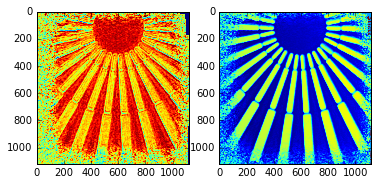

In [17]:
recon.init_obj_flag = False                #True to start with a random guess. False to load a pre-existing array

recon.obj = object
# recon.obj = npy.load('./obj_init.npy')

recon.solution = object

# update object
recon.start_update_object = n_iterations + 2

recon.amp_max = 1.  #up limit of allowed object amplitude range
recon.amp_min = 0.       #low limit of allowed object amplitude range
recon.pha_max = npy.pi/2.       #up limit of allowed object phase range
recon.pha_min = -npy.pi/2.         #low limit of allowed object phase range

recon.alpha = 1.e-8

plt.subplot(1,2,1)
plt.imshow(abs(recon.obj))
plt.subplot(1,2,2)
plt.imshow(np.angle(recon.obj))

Algorithm parameters

In [18]:
recon.n_iterations = n_iterations   #number of iterations

recon.start_ave = 0.8

recon.sf_flag = False # use numpy fft

recon.dm_version = 1 # difference map : run_parallel_over_points
recon.processes = 1
recon.beta = 0.9 #reconstruction feedback parameters

recon.position_correction_flag = False
recon.position_correction_start = 50
recon.position_correction_step = 10

Output parameters

In [19]:
recon.scan_num = scan_num  # scan number
recon.sign = sign          # saving file name

Advanced parameters

In [20]:
recon.mode_flag = mode_flag
recon.save_tmp_pic_flag = False
recon.prb_mode_num = 10
recon.obj_mode_num = 1

recon.multislice_flag = multislice_flag
if recon.multislice_flag:
    recon.slice_num = 3
    recon.slice_spacing_m = 50.e-6

#parameters for partial coherence calculation
recon.pc_flag = False
recon.update_coh_flag = False
recon.kernal_n = 16           # kernal size
recon.pc_sigma = 0.2          # initial guess of kernal sigma

In [21]:
# recon.recon_code = __file__        #Copy the code
recon.recon_ptycho()

0.00275 0.00275
1119.0 1120.0
0 object_chi= 0.0 probe_chi= 0.597527918764 diff_chi= 0.675637680164


ptycho_trans.py:1341: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if None in results:


1 object_chi= 0.0 probe_chi= 0.555065201557 diff_chi= 0.699895072669
2 object_chi= 0.0 probe_chi= 0.33427263349 diff_chi= 0.700073673326
3 object_chi= 0.0 probe_chi= 0.319556934629 diff_chi= 0.719696191473
4 object_chi= 0.0 probe_chi= 0.266610470667 diff_chi= 0.723029705828
5 object_chi= 0.0 probe_chi= 0.270239410979 diff_chi= 0.723141167088
6 object_chi= 0.0 probe_chi= 0.23075849612 diff_chi= 0.711874327577
7 object_chi= 0.0 probe_chi= 0.241478693903 diff_chi= 0.690751643828
8 object_chi= 0.0 probe_chi= 0.231232095183 diff_chi= 0.665792306685
9 object_chi= 0.0 probe_chi= 0.242263918392 diff_chi= 0.634210826078
10 object_chi= 0.0 probe_chi= 0.241670680803 diff_chi= 0.594376448266
11 object_chi= 0.0 probe_chi= 0.243255119874 diff_chi= 0.541664248901
12 object_chi= 0.0 probe_chi= 0.240337116295 diff_chi= 0.472373958016
13 object_chi= 0.0 probe_chi= 0.230335595939 diff_chi= 0.390046487449
14 object_chi= 0.0 probe_chi= 0.2071315597 diff_chi= 0.310230086558
15 object_chi= 0.0 probe_chi= 0.1

In [22]:
# recon.save_recon()

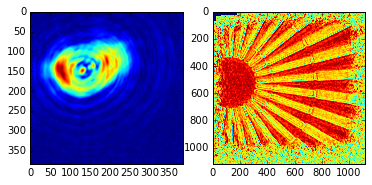

In [23]:
# recon.display_recon()
plt.subplot(121)
plt.imshow(np.flipud(np.abs(recon.prb.T)))
plt.subplot(122)
plt.imshow(np.flipud(np.abs(recon.obj.T)))

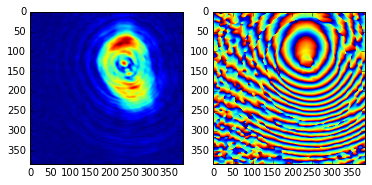

In [24]:
plt.subplot(121)
plt.imshow(np.abs(recon.prb))
plt.subplot(122)
plt.imshow(np.angle(recon.prb))